In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from utils import *
from model import * 
from matplotlib.patches import Ellipse
import scipy.io
from scipy.ndimage import gaussian_filter
from tqdm import tqdm 

In [24]:
def get_J(params): 
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    return J 

def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def find_amps(params, get_J, T, n_frames, init):
    m = FHN_det(params, get_J)
    res = m.evolve(T, int(n_frames), init)
    amps = np.fft.rfft(res[:, -170:], axis=-1) 
    return np.abs(amps)**2 

In [3]:
# params in the order of epsilon, gamma, mu, c 
# # estimation from spinning rod + direct measurements 
gamma = 1
c =  15.5*gamma
mu = 0.09
epsilon = 0.35
beta = 15*gamma
sigma = np.sqrt(epsilon)*0.52


params = [epsilon, gamma, mu, c, beta, sigma]

T = 1e3
n_frames = int(T)
init = [1, 1]

N = 200
epsilons = np.linspace(0.0001, 0.6, N)
mus = np.linspace(0.0, 0.5, N)

In [4]:
Re = np.empty((N, N))
Im = np.empty((N, N))
# Amps = np.empty((N, N))

for (i, epsilon) in enumerate(epsilons): 
    for (j, mu) in enumerate(mus):
        J = get_J([epsilon, gamma, mu, c]) 
        eigvals = np.linalg.eigvals(J)
        Re[i, j] = np.real(np.max(eigvals))
        Im[i, j] = np.imag(np.max(eigvals))
        
        # params = [epsilon, gamma, mu, c, beta]
        # amps = find_amps(params, get_J, T, n_frames, init)
        # Amps[i, j] = np.sum(amps[1:])/n_frames 

In [17]:
np.save('Data/param_sweep_amps.npy', Amps)
np.save('Data/param_sweep_epsilons.npy', epsilons)
np.save('Data/param_sweep_mus.npy', mus)

In [77]:
Amps = np.load('Data/param_sweep_amps.npy')
epsilons = np.load('Data/param_sweep_epsilons.npy')
mus = np.load('Data/param_sweep_mus.npy')   

-69.14008549510665 4.6339355776558895


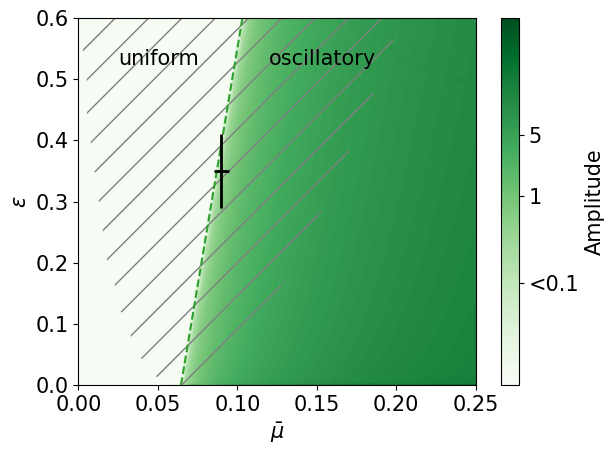

In [100]:
epsilon_map = 0.35
epsilon_frac_err = 0.1

mu_map = 0.09
mu_frac_err = 0.05

centre = [mu_map, epsilon_map]
width = mu_frac_err*mu_map 
height = epsilon_frac_err*epsilon_map

plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=15)

# plot the amplitudes of oscillation 
log_amps = np.log(Amps)
print(np.min(log_amps), np.max(log_amps))
amps_inrange = np.clip(log_amps, -5, 5)
ctf = plt.contourf(mus, epsilons, amps_inrange, levels=100, vmin = -5, vmax = 5, cmap='Greens') 
cbar = plt.colorbar(ctf, boundaries=np.linspace(1, 10, 100))
cbar.set_label('Amplitude')
cbar.set_ticks([np.log(0.1), 0, np.log(5)])
cbar.set_ticklabels(["<0.1", 1, 5])

# plot the contour of the Im eigenvalues 
plt.rcParams['hatch.color'] = 'grey'
plt.contourf(mus, epsilons, Im, levels=[0.01, 1], hatches=['/', None], alpha=0)

# plot the contour of the Re eigenvalues 
cs = plt.contour(mus, epsilons, Re, levels=[0], colors='tab:green', linestyles='--', alpha=1) 

# plot the MAP values 
plt.errorbar([mu_map], [epsilon_map], xerr=mu_frac_err*mu_map, yerr=epsilon_frac_err*epsilon, color='black', linewidth=2)

plt.text(0.025, 0.55, r'uniform', fontsize=15, verticalalignment='top', )
plt.text(0.12, 0.55, r'oscillatory', fontsize=15, verticalalignment='top', )

plt.xlabel(r'$\bar{\mu}$')
plt.ylabel(r'$\epsilon$')
plt.xlim([0, 0.25])
plt.ylim([0, 0.6])
plt.tight_layout()
plt.savefig('Figures/param_sweep.png')
plt.show() 

In [31]:
gamma = 1 
Ls = np.arange(5, 20, 1)
ratios = (Ls-1)/10 
N = len(ratios)
c_map = 15.5
c_traj = c_map*ratios
mu_map = 0.09
mu_traj = mu_map/ratios**2
epsilon_map = 0.35
epsilon_traj = epsilon_map/ratios**4 
sigma_map = np.sqrt(epsilon_map)*0.52
sigma_traj = sigma_map/ratios**1.5

std_ratios = [0.1, 0.1, 0.05, 0.15, 0.15]


T = 2000
n_frames = int(T)
init = [10, 10]
freqs = np.fft.rfftfreq(170)*2*np.pi 

Im = np.empty((N))
theta_freq = [] 
n_samples = 100

for (i, (mu, c, epsilon, sigma)) in tqdm(enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj))):
    mean = np.array([epsilon, gamma, mu, c, beta])
    std = mean*np.array(std_ratios)

    re_sample = [] 
    im_sample = [] 
    freq_sample = [] 
    for n in range(n_samples): 
        params = np.random.normal(mean, std)
        J = get_J(params)
        eigvals = np.linalg.eigvals(J)
        re_sample.append(np.real(np.max(eigvals)))
        im_sample.append(np.imag(np.max(eigvals)))
        amps = find_amps(params, get_J, T, n_frames, init)
        freq_sample.append(freqs[np.argmax(amps[0])])

    re_sample = np.array(re_sample)
    im_sample = np.array(im_sample)
    if np.sum(re_sample > 0) > 0: 
        Im[i] = np.mean(im_sample[re_sample > 0])
    else: 
        Im[i] = 0 
    theta_freq.append(freq_sample)

15it [00:27,  1.86s/it]


In [26]:
period_sim = 2*np.pi/np.array(theta_freq)
period_analytic = 2*np.pi/Im 

period_sim[period_sim > 50] = 0 
period_analytic[period_analytic > 50] = 0

np.savetxt('Data/period_sim.csv', period_sim)
np.savetxt('Data/period_analytic.csv', period_analytic)

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_69493/1992751122.py:1: RuntimeWarning: divide by zero encountered in divide
  period_sim = 2*np.pi/np.array(theta_freq)
/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_69493/1992751122.py:2: RuntimeWarning: divide by zero encountered in divide
  period_analytic = 2*np.pi/Im


In [27]:
mat_data = scipy.io.loadmat('Data/PeriodOsc.mat')
period_exp = mat_data['N_Period']

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


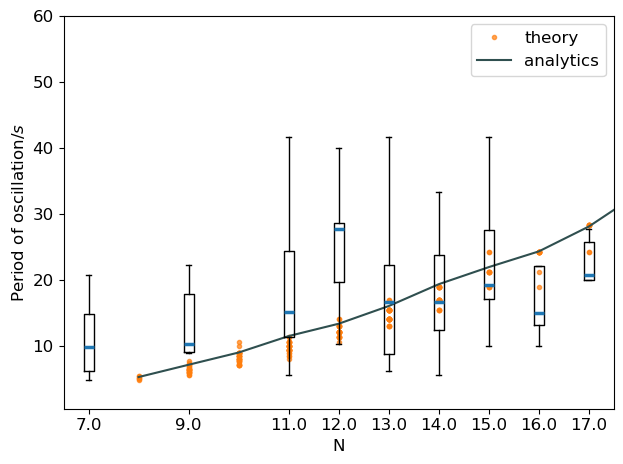

In [30]:
from matplotlib.lines import Line2D

plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', size=12)

plt.axhline(y=0, c='k')


Ns = np.unique(period_exp[:, 0])
data_by_x = [period_exp[period_exp[:, 0] == N, 1] for N in Ns]
m = list(map(np.mean, data_by_x))
s = list(map(np.std, data_by_x))

print(Ls)

plt.plot(Ls, period_sim[:, 0], 'tab:orange', marker='o', markersize=3, linestyle='none', label=r'theory', alpha=0.7, markeredgewidth=1)
plt.plot(Ls, period_sim, 'tab:orange', marker='o', markersize=3, linestyle='none', alpha=0.7, markeredgewidth=1)
plt.plot(ratios[period_analytic > 1]*10+1, period_analytic[period_analytic > 1], c='darkslategrey', alpha=1, label=r'analytics')
# plt.plot(period_exp[:, 0], period_exp[:, 1], 'grey', marker='o', markersize=2, linestyle='none', label=r'experiments')
plt.legend(loc='upper right') 


medianprops = dict(linestyle='-', linewidth=2.5, color='tab:blue')
boxprops={"facecolor": 'tab:blue'}
plt.boxplot(data_by_x, positions=Ns, widths=0.2, showmeans=False, medianprops=medianprops, showfliers=False)

plt.xlim([6.5, 17.5])
plt.ylim([0.5, 60])
# plt.xticks([7, 9, 11, 13, 15, 17 ], ['7', '9', '11', '13', '15', '17'])
plt.xlabel('N')
plt.ylabel(r'Period of oscillation/$s$')
plt.tight_layout()
plt.savefig('Figures/re_im_eig.pdf')
plt.show()

In [150]:
gamma = 1 
ratios = (np.arange(5, 20)-1)/10
c_map = 15.5 
c_traj = c_map*ratios
mu_map = 0.09
mu_traj = mu_map/ratios**2
epsilon_map = 0.35
epsilon_traj = epsilon_map/ratios**4 

beta = 15*gamma
sigma_traj = 0.052*np.sqrt(epsilon_map)/ratios**1.5

n_repeats = 5
init = [0, 0]



In [151]:
stds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    
    dt = max(1/epsilon/5e3, 6.6e-3)
    dt = min(dt, 0.011)
    T = max(1/epsilon*30, 170)
    n_frames = int(T/0.033)
    print(ratios[i]*10+1, dt, T)
    
    params = [epsilon, gamma, mu, c, beta, sigma]
    m = FHN(params, convert_params, m_err = [0.002, 0.04])
    results =  np.array(m.evolve(T, dt, int(n_frames), n_repeats))
    results = results[:, :, -5000:]

    std = np.std(results[:, 0, :], axis=-1)
    stds.append(std) 

np.save('Data/theta_var.npy', np.array(stds)**2)

5.0 0.0066 170
6.0 0.0066 170
7.0 0.0066 170
8.0 0.0066 170
9.0 0.0066 170
10.0 0.0066 170
11.0 0.0066 170
12.0 0.0066 170
13.0 0.0066 177.73714285714289
14.0 0.0066 244.8085714285715
15.0 0.0066 329.28
16.0 0.0066 433.92857142857144
17.0 0.0066 561.737142857143
18.0 0.0066 715.8942857142856
19.0 0.0066 899.7942857142857


In [165]:
gamma = 1 
ratios = (np.arange(5, 20)-1)/10
c_map = 0
c_traj = c_map*ratios
mu_map = 0
mu_traj = mu_map/ratios**2
epsilon_map = 0.35
epsilon_traj = epsilon_map/ratios**4 

beta = 0 
sigma_traj = 0.0007/ratios**1.5

n_repeats = 2
init = [0, 0]

In [166]:
stds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    
    pred = np.sqrt(sigma**2/(2*epsilon))
    params = [epsilon, gamma, mu, c, beta, sigma]
    m = FHN(params, convert_params, m_err = [0.002, 0.04])

    dt = max(1/epsilon/1e3, 1.1e-3)
    T = max(1/epsilon*30, 170)
    n_frames = int(T/0.033)
    print(ratios[i]*10+1, dt, T)
    results =  np.array(m.evolve(T, dt, int(n_frames), n_repeats))
    std = np.std(results[:, 0, -5000:], axis=-1)
    stds.append(std) 

np.save('Data/eq_var.npy', np.array(stds)**2)
        

5.0 0.0011 170
6.0 0.0011 170
7.0 0.0011 170
8.0 0.0011 170
9.0 0.0011702857142857146 170
10.0 0.0018745714285714286 170
11.0 0.002857142857142857 170
12.0 0.004183142857142859 170
13.0 0.005924571428571429 177.73714285714289
14.0 0.008160285714285717 244.8085714285715
15.0 0.010976 329.28
16.0 0.014464285714285716 433.92857142857144
17.0 0.018724571428571434 561.737142857143
18.0 0.023863142857142854 715.8942857142856
19.0 0.029993142857142857 899.7942857142857


In [167]:
preds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    preds.append(sigma**2/(2*epsilon))


In [168]:
var = np.load('Data/theta_var.npy')
mean = np.mean(var, axis=-1)
err = np.std(var, axis=-1)

var_eq = np.load('Data/eq_var.npy')
m_eq = np.mean(var_eq, axis=-1)
err_eq = np.std(var_eq, axis=-1)

In [169]:
mat_data = scipy.io.loadmat('Data/VarTheta.mat')
exp_var = mat_data['VarTheta']
exp_var[:, 1] *= (np.pi/180)**2

L_exp = np.unique(exp_var[:, 0])
mean_exp = [np.mean(exp_var[exp_var[:, 0] == L][:, 1]) for L in L_exp]
std_exp = [np.std(exp_var[exp_var[:, 0] == L][:, 1]) for L in L_exp]

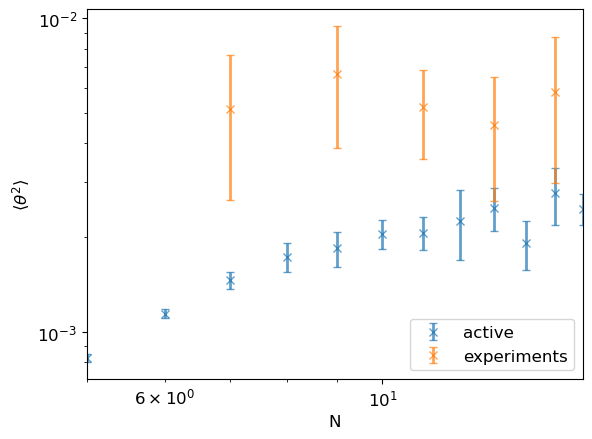

In [172]:
Ls = ratios*10+1
plt.errorbar(Ls, mean, yerr=err, fmt='x', barsabove=True, capsize=3, alpha=0.7, label=r'active', linewidth=2)
# plt.errorbar(Ls, m_eq, yerr=err_eq, fmt='x', barsabove=True, capsize=3, alpha=0.7, label=r'eq', linewidth=2)
plt.errorbar(L_exp, mean_exp, yerr=std_exp, fmt='x', barsabove=True, capsize=3, alpha=0.7, label=r'experiments', linewidth=2)
# plt.plot(Ls, preds, 'k--', label=r'eq theory')
plt.legend() 
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\langle \theta^2 \rangle$')
plt.xlabel(r'N')
plt.xlim([5, 16])
plt.show() 